<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525600 entries, 0 to 525599
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Timestamp      525600 non-null  datetime64[ns]
 1   GHI            525600 non-null  float64       
 2   DNI            525600 non-null  float64       
 3   DHI            525600 non-null  float64       
 4   ModA           525600 non-null  float64       
 5   ModB           525600 non-null  float64       
 6   Tamb           525600 non-null  float64       
 7   RH             525600 non-null  float64       
 8   WS             525600 non-null  float64       
 9   WSgust         525600 non-null  float64       
 10  WSstdev        525600 non-null  float64       
 11  WD             525600 non-null  float64       
 12  WDstdev        525600 non-null  float64       
 13  BP             525600 non-null  int64         
 14  Cleaning       525600 non-null  int64         
 15  

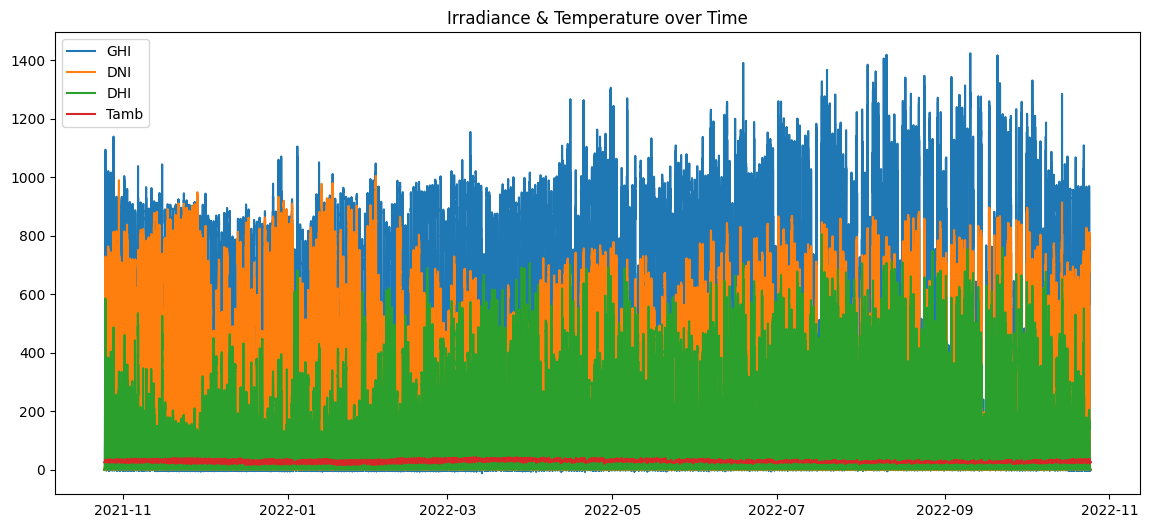

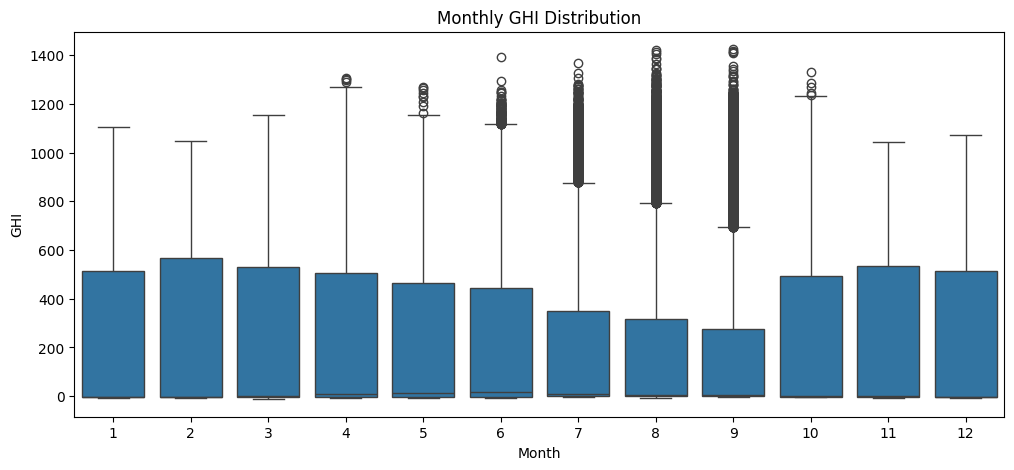

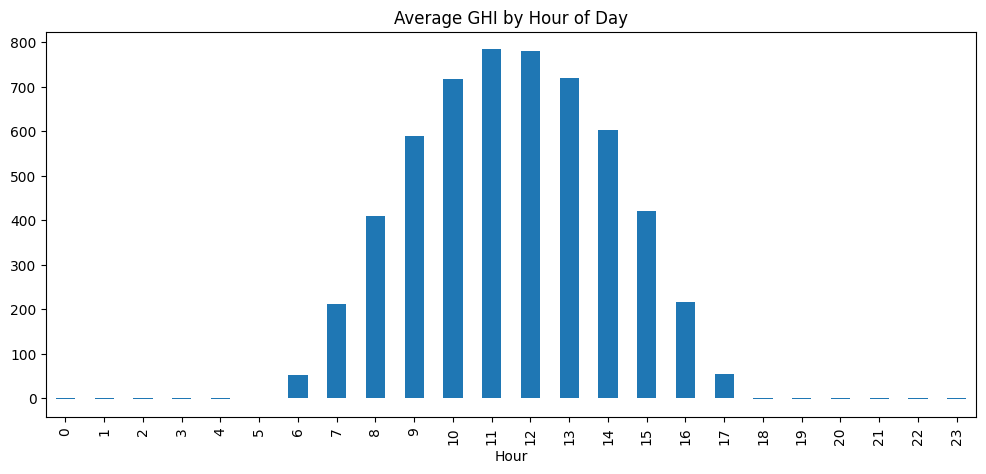

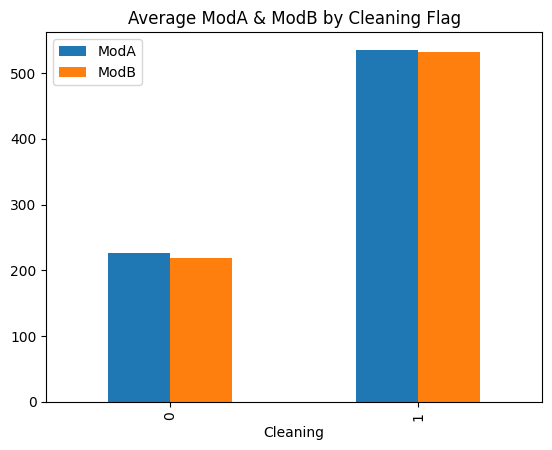

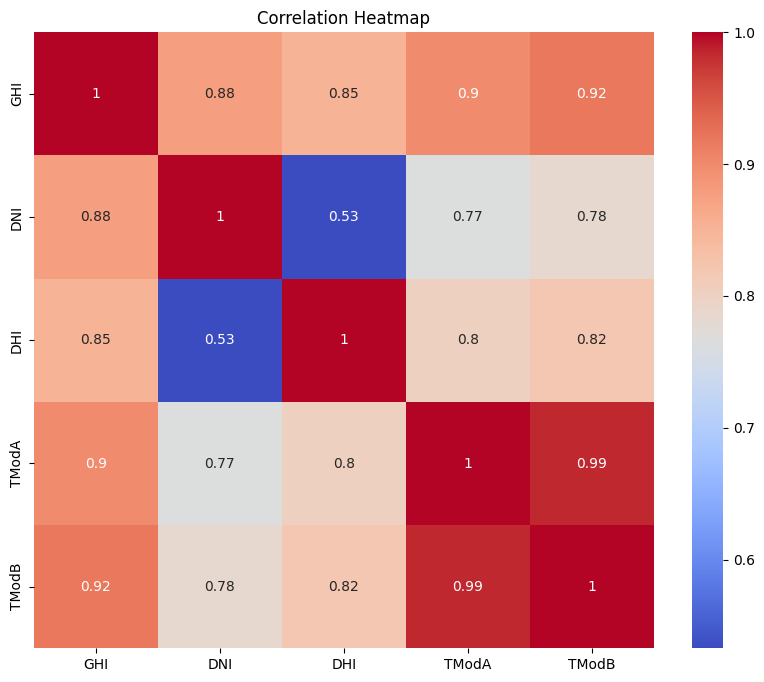

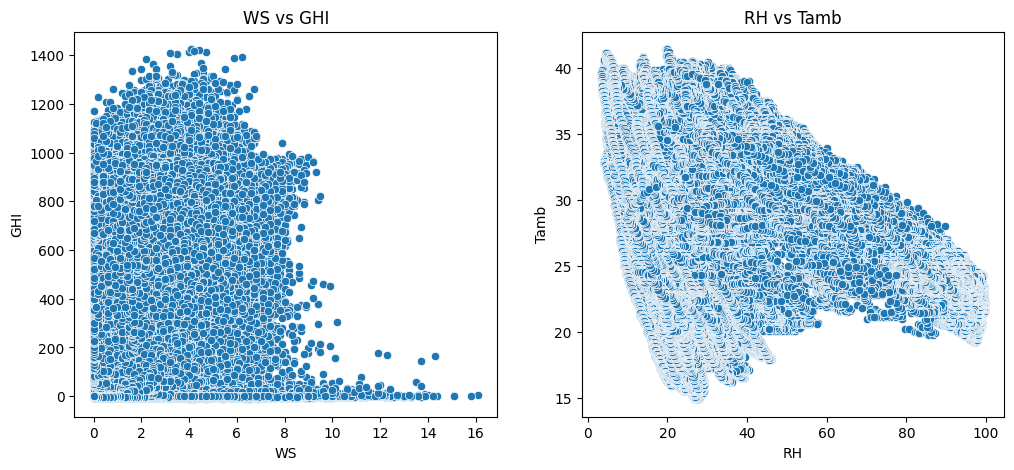

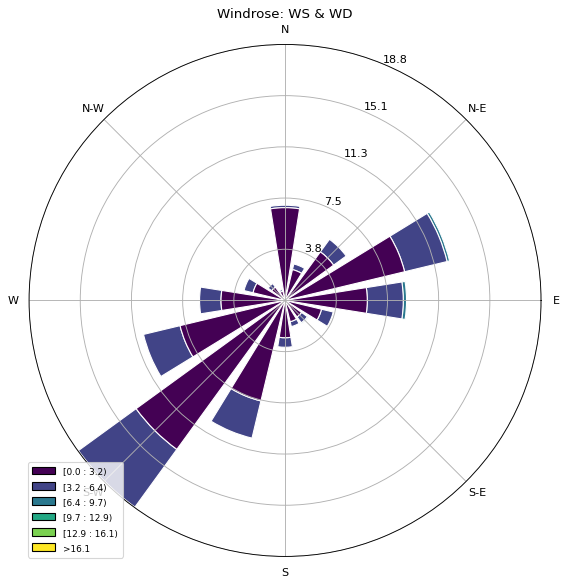

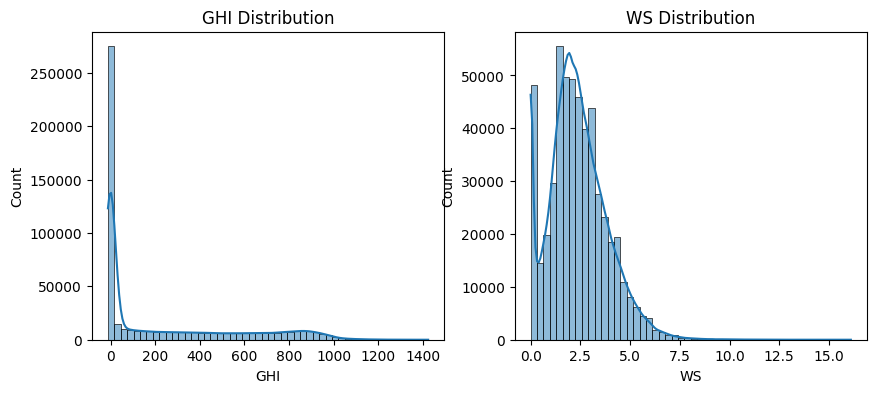

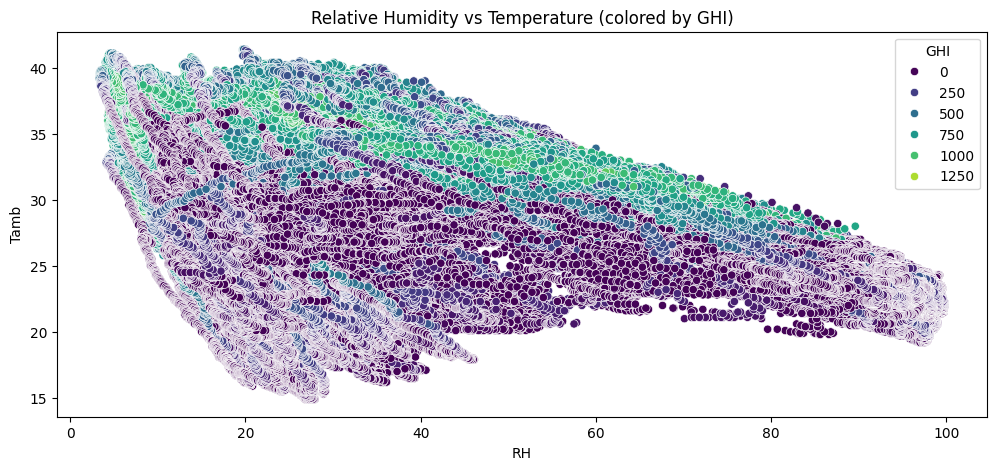

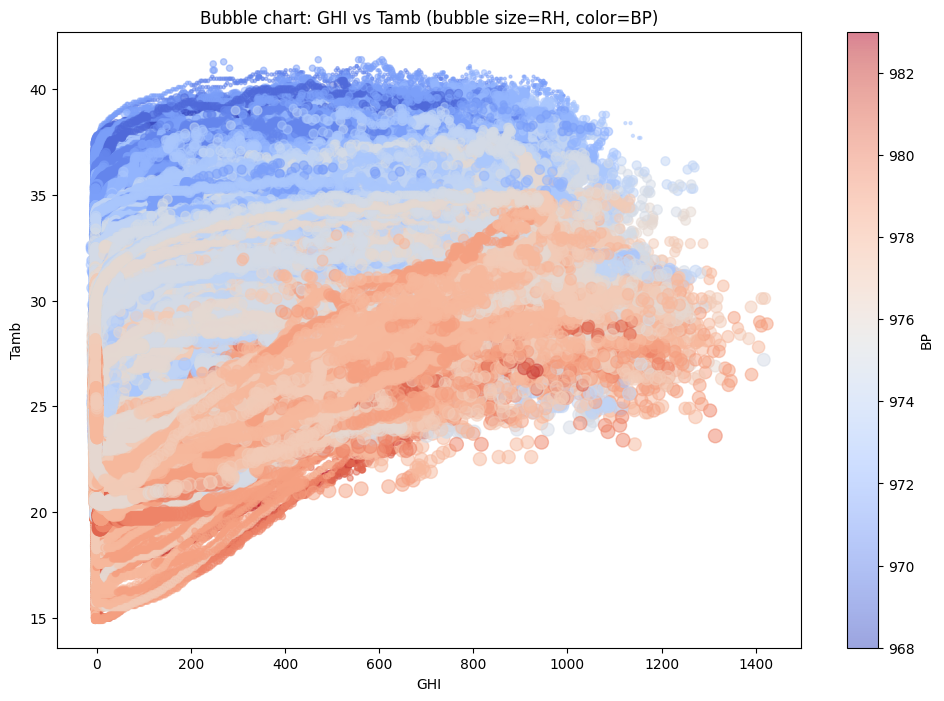

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import matplotlib.cm as cm
from windrose import WindroseAxes

# Load data
df = pd.read_csv('../data/togo-dapaong_qc.csv', parse_dates=['Timestamp'])

# Quick look
print(df.info())
print(df.head())

# -------------------------------
# 1. Summary Statistics & Missing Value Report
# -------------------------------
print(df.describe())
missing_counts = df.isna().sum()
print("Missing values per column:\n", missing_counts)

# List columns with >5% nulls
missing_percent = (missing_counts / len(df)) * 100
print("Columns with >5% missing values:\n", missing_percent[missing_percent > 5])

# -------------------------------
# 2. Outlier Detection & Basic Cleaning
# -------------------------------
cols_to_check = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# Compute Z-scores
df_z = df[cols_to_check].apply(zscore)

# Flag rows with any |Z| > 3
outliers = (df_z.abs() > 3).any(axis=1)
print(f"Outliers detected: {outliers.sum()} rows")

# Option: Remove outliers or impute (median) missing values in key columns
# Impute missing values with median for these columns
for col in cols_to_check:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

# -------------------------------
# 3. Time Series Analysis
# -------------------------------
df.set_index('Timestamp', inplace=True)
df['Month'] = df.index.month
df['Hour'] = df.index.hour

plt.figure(figsize=(14,6))
plt.plot(df['GHI'], label='GHI')
plt.plot(df['DNI'], label='DNI')
plt.plot(df['DHI'], label='DHI')
plt.plot(df['Tamb'], label='Tamb')
plt.title('Irradiance & Temperature over Time')
plt.legend()
plt.show()

# Monthly GHI boxplot
plt.figure(figsize=(12,5))
sns.boxplot(x='Month', y='GHI', data=df)
plt.title('Monthly GHI Distribution')
plt.show()

# Hourly mean GHI
hourly_mean = df.groupby('Hour')['GHI'].mean()
plt.figure(figsize=(12,5))
hourly_mean.plot(kind='bar')
plt.title('Average GHI by Hour of Day')
plt.show()

# -------------------------------
# 4. Cleaning Impact
# -------------------------------
if 'Cleaning' in df.columns:
    df.groupby('Cleaning')[['ModA', 'ModB']].mean().plot(kind='bar')
    plt.title('Average ModA & ModB by Cleaning Flag')
    plt.show()
else:
    print("No 'Cleaning' column found")

# -------------------------------
# 5. Correlation & Relationship Analysis
# -------------------------------
plt.figure(figsize=(10,8))
corr = df[['GHI', 'DNI', 'DHI', 'TModA', 'TModB']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Scatter plots
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.scatterplot(x='WS', y='GHI', data=df)
plt.title('WS vs GHI')

plt.subplot(1,2,2)
sns.scatterplot(x='RH', y='Tamb', data=df)
plt.title('RH vs Tamb')
plt.show()

# -------------------------------
# 6. Wind & Distribution Analysis
# -------------------------------
# Windrose plot
ax = WindroseAxes.from_ax()
ax.bar(df['WD'], df['WS'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.title('Windrose: WS & WD')
plt.show()

# Histograms
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(df['GHI'], bins=50, kde=True)
plt.title('GHI Distribution')

plt.subplot(1,2,2)
sns.histplot(df['WS'], bins=50, kde=True)
plt.title('WS Distribution')
plt.show()

# -------------------------------
# 7. Temperature Analysis
# -------------------------------
plt.figure(figsize=(12,5))
sns.scatterplot(x='RH', y='Tamb', hue='GHI', palette='viridis', data=df)
plt.title('Relative Humidity vs Temperature (colored by GHI)')
plt.show()

# -------------------------------
# 8. Bubble Chart
# -------------------------------
plt.figure(figsize=(12,8))
sizes = df['RH']  # Bubble size
plt.scatter(df['GHI'], df['Tamb'], s=sizes, alpha=0.5, c=df['BP'], cmap='coolwarm')
plt.xlabel('GHI')
plt.ylabel('Tamb')
plt.title('Bubble chart: GHI vs Tamb (bubble size=RH, color=BP)')
plt.colorbar(label='BP')
plt.show()

# -------------------------------
# 9. Export cleaned dataset (do NOT commit CSVs, add to .gitignore)
# -------------------------------
df.to_csv('../data/togo-dapaong_qc_clean.csv', index=True)